In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import glob

In [93]:
train = pd.read_csv("optiver-realized-volatility-prediction/train.csv")

train.shape

(428932, 3)

In [94]:
order_book_training = glob.glob('optiver-realized-volatility-prediction/book_train.parquet/*')

In [95]:
def wap2vol(df):
    # wap2vol stands for WAP to Realized Volatility
    temp = np.log(df).diff() # calculating tik to tik returns
    # returning realized volatility
    return np.sqrt(np.sum(temp**2)) 


In [96]:
def rel_vol_time_id(path):
    # book: book is an order book
    book = pd.read_parquet(path) # order book for a stock id loaded
    # calculating WAP
    p1 = book["bid_price1"]
    p2 = book["ask_price1"]
    s1 = book["bid_size1"]
    s2 = book["ask_size1"]
    
    book["WAP"] = (p1*s2 + p2*s1) / (s1 + s2)
    # calculating realized volatility for each time_id
    transbook = book.groupby("time_id")["WAP"].agg(wap2vol)
    return transbook

In [97]:
%%time 
stock_id = []
time_id = []
relvol = []
for i in order_book_training:
    # finding the stock_id
    temp_stock = int(i.split("=")[1])
    # find the realized volatility for all time_id of temp_stock
    temp_relvol = rel_vol_time_id(i)
    stock_id += [temp_stock]*temp_relvol.shape[0]
    time_id += list(temp_relvol.index)
    relvol += list(temp_relvol)

CPU times: user 40.3 s, sys: 1.48 s, total: 41.8 s
Wall time: 39.1 s


In [98]:
past_volatility = pd.DataFrame({"stock_id": stock_id, "time_id": time_id, "volatility": relvol})
past_volatility

,stock_id,time_id,volatility
0,17,5,0.004091
1,17,11,0.002155
2,17,16,0.002566
3,17,31,0.002221
4,17,62,0.002155
...,...,...,...
428927,98,32751,0.002572
428928,98,32753,0.001231
428929,98,32758,0.002129
428930,98,32763,0.004120


In [99]:
joined = train.merge(past_volatility, on = ["stock_id","time_id"], how = "left")
R2 = round(r2_score(y_true = joined['target'], y_pred = joined['volatility']),3)
print(f'The R2 score of the naive prediction for training set is {R2}')

The R2 score of the naive prediction for training set is 0.628


In [100]:
joined

,stock_id,time_id,target,volatility
0,0,5,0.004136,0.004499
1,0,11,0.001445,0.001204
2,0,16,0.002168,0.002369
3,0,31,0.002195,0.002574
4,0,62,0.001747,0.001894
...,...,...,...,...
428927,126,32751,0.003461,0.003691
428928,126,32753,0.003113,0.004104
428929,126,32758,0.004070,0.003118
428930,126,32763,0.003357,0.003661


In [101]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

In [102]:
print(f'The RMSPE score of the native prediciton for the training set is {rmspe(joined["target"], joined["volatility"])}')

The RMSPE score of the native prediciton for the training set is 0.34135449018801606


## OLS

In [147]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# for training
def linear_training(X,y,degree):
    # instantiating polynomial features
    polyfeat = PolynomialFeatures(degree = degree)
    linreg = LinearRegression()
    # preprocessing the training data
    x = np.array(X).reshape(-1,1)
    # creating the polynomial features
    X_ = polyfeat.fit_transform(x)
    # training the model
    weights = 1/np.square(y)
    return linreg.fit(X_, np.array(y).reshape(-1,1), sample_weight = weights)


stock_id_train = train.stock_id.unique() # all stock_id for the train set
models = {} # dictionary for holding trained models for each stock_id
degree = 2
for i in stock_id_train:
    temp = joined[joined["stock_id"]==i]
    X = temp["volatility"]
    y = temp["target"]
    models[i] = linear_training(X,y,degree)

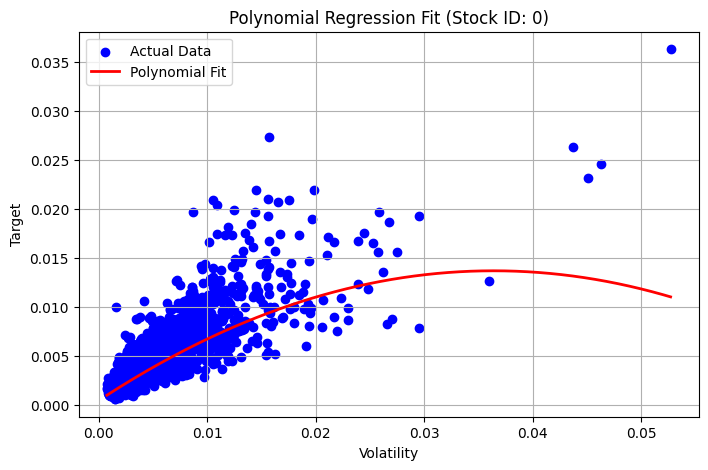

In [148]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_fit(stock_id, models, joined, degree):
    # Extract data for this stock
    temp = joined[joined["stock_id"] == stock_id]
    X = temp["volatility"].values
    y = temp["target"].values
    
    # Get model for this stock
    model = models[stock_id]
    
    # Prepare a range of volatility values for smooth curve
    x_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    polyfeat = PolynomialFeatures(degree=degree)
    X_poly = polyfeat.fit_transform(x_range)
    
    # Predict with the model
    y_pred = model.predict(X_poly)
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(X, y, color='blue', label='Actual Data')
    plt.plot(x_range, y_pred, color='red', linewidth=2, label='Polynomial Fit')
    plt.title(f"Polynomial Regression Fit (Stock ID: {stock_id})")
    plt.xlabel("Volatility")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: plot for the first stock ID
plot_model_fit(stock_id_train[0], models, joined, degree)

In [153]:
def linear_inference(models, stock_id, past_volatility, degree):
    model = models[stock_id]
    polyfeat = PolynomialFeatures(degree = degree)
    return model.predict(polyfeat.fit_transform([[past_volatility]]))[0][0]

In [154]:
submission = pd.DataFrame({"stock_id": [], "time_id": [], "pred": []})

submission[["stock_id","time_id"]] = past_volatility[["stock_id","time_id"]]

In [140]:
submission["target"] = past_volatility.apply(lambda x: linear_inference(models,\
                                                                            x.stock_id,\
                                                                            x.volatility,\
                                                                            degree),\
                                                 axis = 1)

In [141]:
submission.drop(columns = ["pred"], inplace = True)

In [142]:
submission.sort_values(by = ["stock_id","time_id"], inplace = True)

In [143]:
submission.rename(columns = {"target": "pred"}, inplace = True)

In [144]:
joined2 = train.merge(submission, on = ["stock_id","time_id"], how = "left")
R2 = round(r2_score(y_true = joined2['target'], y_pred = joined2['pred']),3)
print(f'The R2 score of the naive prediction for training set is {R2}')

The R2 score of the naive prediction for training set is 0.737


In [145]:
joined2

,stock_id,time_id,target,pred
0,0,5,0.004136,0.003546
1,0,11,0.001445,0.001338
2,0,16,0.002168,0.002126
3,0,31,0.002195,0.002265
4,0,62,0.001747,0.001805
...,...,...,...,...
428927,126,32751,0.003461,0.003363
428928,126,32753,0.003113,0.003673
428929,126,32758,0.004070,0.002928
428930,126,32763,0.003357,0.003341


In [146]:
rmspe(joined2["target"], joined2["pred"])

np.float64(0.24998571682357393)